In [130]:
import numpy as np
from math import*
import pickle
import matplotlib.pyplot as plt
import control.matlab as cm


In [131]:

#       .
#       x = Ax + Bu
#       -    -    -

# with
#     x = [u/V alpha theta qc/V u_g/V alpha_g alpha_g*]'
# and
#     u = [delta_e w_1 w_3]'.



V = 189.6
m = 5445
twmuc = 2*147
KY2 = 0.950
c = 2.022
S = 24.2
lh = 5.5

xcg = 0.3 * c
W = 53361
b = 13.36
h = 6096
rho = 0.6528
mub = 22
muc = 157
KX2 = 0.013
KZ2 = 0.037
KXZ = 0.002

# TURBULENCE PARAMETERS
sigma = 2
Lg = 150
sigmaug_V = sigma/V
sigmaag = sigma/V

# AIRCRAFT SYMMETRIC AERODYNAMIC DERIVATIVES :
CX0 = 0.0000
CZ0 = -0.1620
Cm0 = 0.0000
CXu = -0.0600
CZu = -0.3240
Cmu = 0.0000
CXa = 0.0545
CZa = -5.8000
Cma = -0.5350
CXq = 0.0000
CZq = -4.3800
Cmq = -8.0000
CXd = 0.0000
CZd = -0.5798
Cmd = -1.4440
CXfa = 0.0000
CZfa = -1.8300
Cmfa = -4.7500
CZfug = 0.0000
Cmfug = -Cm0*lh/c
CZfag = CZfa-CZq
Cmfag = Cmfa-Cmq

# CALCULATION OF AIRCRAFT SYMMETRIC STABILITY DERIVATIVES
xu = (V/c)*(CXu/twmuc)
xa = (V/c)*(CXa/twmuc)
xt = (V/c)*(CZ0/twmuc)
xq = 0
xd = (V/c)*(CXd/twmuc)
xug = xu
xfug = 0
xag = xa
xfag = 0

zu = (V/c)*(CZu/(twmuc-CZfa))
za = (V/c)*(CZa/(twmuc-CZfa))
zt = (V/c)*(-CX0/(twmuc-CZfa))
zq = (V/c)*((CZq+twmuc)/(twmuc-CZfa))
zd = (V/c)*(CZd/(twmuc-CZfa))
zug = zu
zfug = (V/c)*(CZfug/(twmuc-CZfa))
zag = za
zfag = (V/c)*(CZfag/(twmuc-CZfa))

mu = (V/c)*((Cmu+CZu*Cmfa/(twmuc-CZfa))/(twmuc*KY2))
ma = (V/c)*((Cma+CZa*Cmfa/(twmuc-CZfa))/(twmuc*KY2))
mt = (V/c)*((-CX0*Cmfa/(twmuc-CZfa))/(twmuc*KY2))
mq = (V/c)*(Cmq+Cmfa*(twmuc+CZq)/(twmuc-CZfa))/(twmuc*KY2)
md = (V/c)*((Cmd+CZd*Cmfa/(twmuc-CZfa))/(twmuc*KY2))
mug = mu
mfug = (V/c)*(Cmfug+CZfug*Cmfa/(twmuc-CZfa))/(twmuc*KY2)
mag = ma
mfag = (V/c)*(Cmfag+CZfag*Cmfa/(twmuc-CZfa))/(twmuc*KY2)

# STATE- AND INPUT MATRICES
A = np.mat([[xu, xa, xt, 0,    xug,                  xag,       0],
            [zu, za, zt, zq,   zug-zfug*V/Lg *
                (c/V),  zag,       zfag*(c/V)],
            [0,  0,  0,  V/c,  0,                    0,         0],
            [mu, ma, mt, mq,   mug-mfug*V/Lg *
                (c/V),  mag,       mfag*(c/V)],
            [0,  0,  0,  0,   -V/Lg,                 0,         0],
            [0,  0,  0,  0,    0,                    0,         1],
            [0,  0,  0,  0,    0,                   -(V/Lg)**2, -2*V/Lg]])

B = np.mat([[xd, 0,                                 0],
            [zd, zfug*(c/V)*sigmaug_V*sqrt(2*V/Lg),
            zfag*(c/V)*sigmaag*sqrt(3*V/Lg)],
            [0,  0,                                 0],
            [md, mfug*(c/V)*sigmaug_V*sqrt(2*V/Lg),
            mfag*(c/V)*sigmaag*sqrt(3*V/Lg)],
            [0,  sigmaug_V*sqrt(2*V/Lg),            0],
            [0,  0,
                sigmaag*sqrt(3*V/Lg)],
            [0,  0,                                 (1-2*sqrt(3))*sigmaag*sqrt((V/Lg)**3)]])

C = np.eye(A.shape[0])
D = np.zeros(B.shape)


# # GAIN FACTORS FOR AUTOPILOT CHAPTER 7 AND DEFINITION OF MATRIX At
# # (approximately "Dead Beat" damping)
# Kt = -0.21
# Kq = -3      # gains on "theta" and "q"
# K = np.array([0, 0, Kt, Kq, 0, 0, 0])  # feedback matrix
# At = A-B[:, 0]*K         # new A matrix = (A - BK) because of feedback


1. Stability Analysis


In [132]:
# Ar only keep 2nd and 4th row and column
# Br only keep 2nd and 4th row
# Cr only keep 2nd and 4th row and column
# Dr only keep 2nd and 4th row
# Ar = A[np.ix_([1, 3], [1, 3])]
# Br = B[[1, 3], :]
# Cr = C[np.ix_([1, 3], [1, 3])]
# Dr = D[[1, 3], :]


In [133]:
# remove u_hat and theta
Ar = A[np.ix_([1, 3, 4, 5, 6], [1, 3, 4, 5, 6])]
Br = B[[1, 3, 4, 5, 6], :]
Cr = C[np.ix_([1, 3, 4, 5, 6], [1, 3, 4, 5, 6])]
Dr = D[[1, 3, 4, 5, 6], :]


In [134]:
print(Ar.shape)
print(Br.shape)
print(Cr.shape)
print(Dr.shape)

(5, 5)
(5, 3)
(5, 5)
(5, 3)


In [135]:
sys = cm.ss(A, B, C, D)
sysr = cm.ss(Ar, Br, Cr, Dr)

In [136]:
# damping ratio and natural frequency
cm.damp(sys)
cm.damp(sysr)


_____Eigenvalue______ Damping___ Frequency_
    -3.043    +3.488j     0.6574      4.629
    -3.043    -3.488j     0.6574      4.629
 -0.009285  +0.06391j     0.1438    0.06458
 -0.009285  -0.06391j     0.1438    0.06458
    -1.264                     1      1.264
    -1.264                     1      1.264
    -1.264                     1      1.264
_____Eigenvalue______ Damping___ Frequency_
    -3.043    +3.488j     0.6573      4.629
    -3.043    -3.488j     0.6573      4.629
    -1.264                     1      1.264
    -1.264                     1      1.264
    -1.264                     1      1.264


(array([4.62884742, 4.62884742, 1.264     , 1.264     , 1.264     ]),
 array([0.65734029, 0.65734029, 1.        , 1.        , 1.        ]),
 array([-3.04272792+3.48827109j, -3.04272792-3.48827109j,
        -1.264     +0.j        , -1.264     +0.j        ,
        -1.264     +0.j        ]))

(array([-3.04301137+3.48817487j, -3.04301137-3.48817487j,
        -0.00928477+0.06391049j, -0.00928477-0.06391049j,
        -1.264     +0.j        , -1.264     +0.j        ,
        -1.264     +0.j        ]),
 array([], dtype=float64))

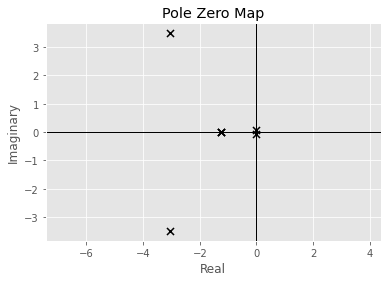

In [137]:
# plot a pole-zero map
cm.pzmap(sys)
# save the figure
# plt.savefig('figures/pzmap_full.pdf', dpi=300, bbox_inches='tight')

(array([-3.04272792+3.48827109j, -3.04272792-3.48827109j,
        -1.264     +0.j        , -1.264     +0.j        ,
        -1.264     +0.j        ]),
 array([], dtype=float64))

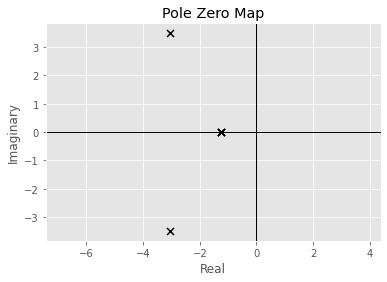

In [138]:
cm.pzmap(sysr)
# plt.savefig('figures/pzmap_red.pdf', dpi=300, bbox_inches='tight')


2. Time-Domain Analysis

In [139]:
sys = cm.ss(A, B, C, D)
sysr = cm.ss(Ar, Br, Cr, Dr)

In [140]:

# TIME AXIS INPUT VECTOR DEFINITION
dt = 0.01
T = 60
t = np.arange(0, T + dt, dt)
N = len(t)

# randn is normal distribution
# INPUT VECTOR DEFINITION
nn = np.zeros((N, 1))                    # zero input elevator
w1 = np.random.randn(N, 1)/sqrt(dt)      # scaled input hor. turbulence,
# note the sqrt(dt) because of lsim
w3 = np.random.randn(N, 1)/sqrt(dt)      # scaled input vert. turbulence,
# note the sqrt(dt) because of lsim
u = np.hstack((nn, nn, w3))             # input vector definition (vertical
# turbulence only, can be changed).

def time_analysis_states(sys, t, u, reduced=False):
    # N rows and 1 column
    y = cm.lsim(sys, u, t)[0]
    if reduced is False:
        # 2x2 plot for t vs y[:, 0] and t vs y[:, 1], etc.
        print('Plotting full state space, time domain analysis')
        plt.figure()
        plt.subplot(2, 2, 1)
        plt.plot(t, y[:, 0])
        plt.xlabel('time [s]')
        plt.ylabel('u/V [-]')
        plt.title('airspeed deviation')

        plt.subplot(2, 2, 2)
        plt.plot(t, y[:, 1]*180/pi)
        plt.xlabel('time [s]')
        plt.ylabel('alpha [deg]')
        plt.title('angle of attack')

        plt.subplot(2, 2, 3)
        plt.plot(t, y[:, 2]*180/pi)
        plt.xlabel('time [s]')
        plt.ylabel('theta [deg]')
        plt.title('pitch angle')

        plt.subplot(2, 2, 4)
        plt.plot(t, y[:, 3]*180/pi)
        plt.xlabel('time [s]')
        plt.ylabel('qc/V [deg]')
        plt.title('pitch rate')
        # space out the plots
        plt.tight_layout()
        # make the plots bigger
        plt.gcf().set_size_inches(10, 8)
        # make the plots more fancy
        plt.style.use('ggplot')
        # plt.savefig('figures/states_vs_t.pdf')
        plt.show()
    else:
        print('Plotting reduced state space, time domain analysis')
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.plot(t, y[:, 0]*180/pi)
        plt.xlabel('time [s]')
        plt.ylabel('alpha [deg]')
        plt.title('angle of attack')
        
        plt.subplot(2, 1, 2)
        plt.plot(t, y[:, 1]*180/pi)
        plt.xlabel('time [s]')
        plt.ylabel('qc/V [deg]')
        plt.title('pitch rate')
        # space out the plots
        plt.tight_layout()
        # make the plots bigger
        plt.gcf().set_size_inches(10, 8)
        # make the plots more fancy
        plt.style.use('ggplot')
        # plt.savefig('figures/states_vs_t_red.pdf')
        plt.show()
        
    return y
        
        
    


Plotting full state space, time domain analysis


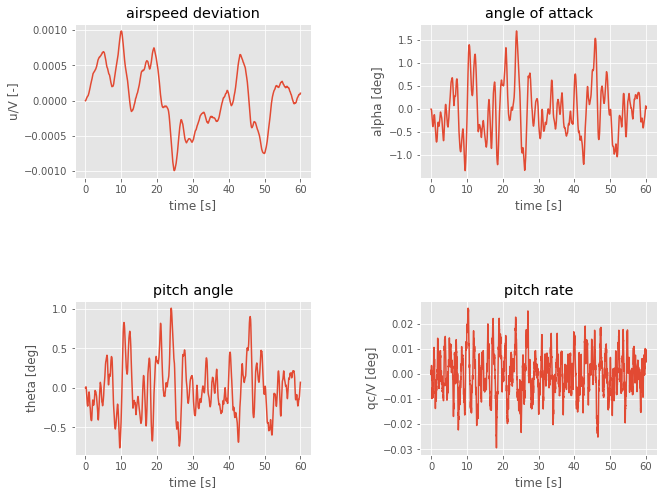

Plotting reduced state space, time domain analysis


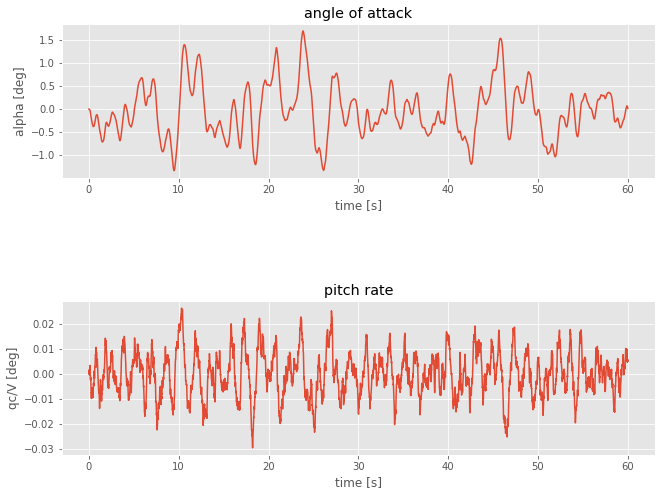

In [141]:
y = time_analysis_states(sys, t, u, reduced=False)
y_red = time_analysis_states(sysr, t, u, reduced=True)


calculating load factor for full state space
calculating load factor for reduced state space


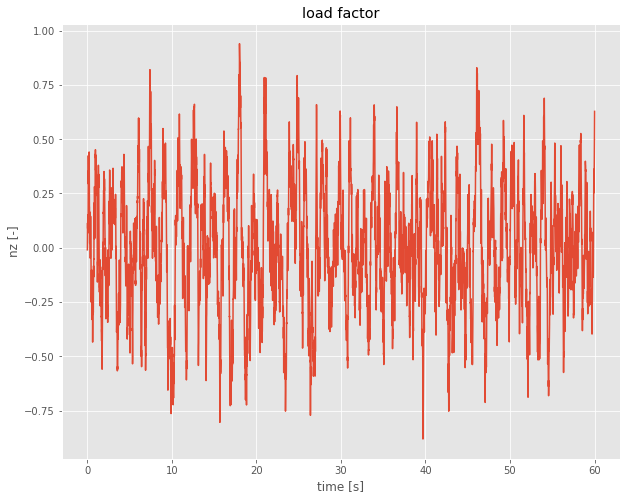

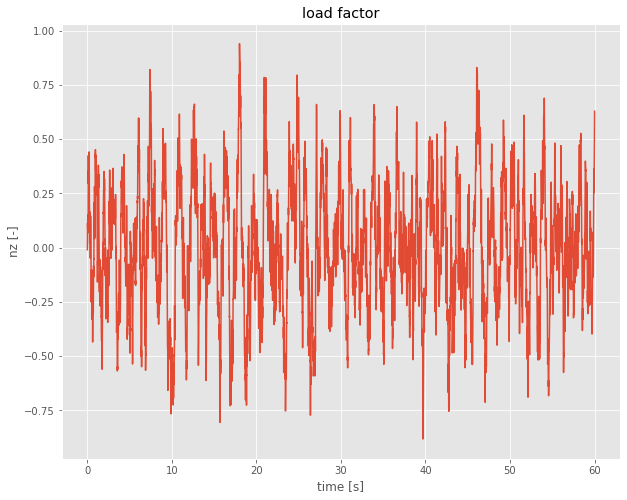

In [142]:
# az = V * (y[:, 2] - y[:, 1])  # V * flight path angle dot
# nz = az / 9.81                   # normal load factor
def load_factor(y, V, dt, reduced = False):
    
    g = 9.81
    if reduced is False:
        print('calculating load factor for full state space')
        qcV = y[:, 3]
        alpha = y[:, 1]
    else:
        print('calculating load factor for reduced state space')
        qcV = y[:, 1]
        alpha = y[:, 0]
    alphanz = alpha
    alphanz = np.hstack((alphanz, np.array([0])))

    nz = (V/g)*((V/c)*qcV-np.diff(alphanz)/dt)
    nz[-1] = nz[-2]
    return nz
# g = 9.81
# qcV = y[:, 3]
# alpha = y[:, 1]
# alphanz = alpha
# alphanz = np.hstack((alphanz, np.array([0])))

# nz = (V/g)*((V/c)*qcV-np.diff(alphanz)/dt)
# nz[-1] = nz[-2]

nz = load_factor(y, V, dt, reduced=False)
nz_red = load_factor(y_red, V, dt, reduced=True)

# plot nz vs t
plt.figure()
plt.plot(t, nz)
plt.xlabel('time [s]')
plt.ylabel('nz [-]')
plt.title('load factor')
# make the plots bigger
plt.gcf().set_size_inches(10, 8)
# save the plot
# plt.savefig('figures/nz_vs_t.pdf')

# plot nz_red vs t
plt.figure()
plt.plot(t, nz_red)
plt.xlabel('time [s]')
plt.ylabel('nz [-]')
plt.title('load factor')
# make the plots bigger
plt.gcf().set_size_inches(10, 8)
# save the plot
# plt.savefig('figures/nz_vs_t_red.pdf')


3. Spectral Analysis


i) analytical PSD using ss representation


In [143]:
Ar.shape[0]

5

In [144]:
# DEFINE MISCELLANEOUS
g  = 9.81                     # gravitational acc [N/kg]

# calculation of the frequency response of the normal acceleration factor

# FREQUENCY AXIS
Nomega = 300
w = np.logspace(-2,2,Nomega)

############################################################################################################

# C and D MATRICES AND SYSTEMS
# full state space
D0 = np.zeros((1, 3))
Calphadot = A[1, :]
Dalphadot = B[1, :]
Sxx = []
for i in range(A.shape[0]):
    Ci = np.zeros(A.shape[0])
    Ci[i] = 1
    print(Ci)
    sys1 = cm.ss(A, B[:,1], Ci, D0[:, 1])
    sys2 = cm.ss(A, B[:,2], Ci, D0[:, 2])
    
    mag = cm.bode(sys1, w, plot=False)[0]
    PSD1 = mag * mag
    mag = cm.bode(sys2, w, plot=False)[0]
    PSD2 = mag * mag
    PSD = PSD1 + PSD2
    Sxx.append(PSD)
    
Snznz = 0
for i in range(1, 3):
    sysalphadot = cm.ss(A, B[:, i], Calphadot, Dalphadot[:, i])
    Cq = np.array([0, 0, 0, 1, 0, 0, 0])
    sysq = cm.ss(A, B[:, i], Cq, D0[:, i])
    Hadotw = cm.frd(sysalphadot, w).fresp
    Hadotw = np.ndarray.flatten(Hadotw)
    Hqw = cm.frd(sysq, w).fresp
    Hqw = np.ndarray.flatten(Hqw)

    Hnz = (V/g)*((V/c)*Hqw - Hadotw)
    mag_i = abs(np.ndarray.flatten(Hnz))
    Snznz_i = mag_i * mag_i
    Snznz += Snznz_i
Sxx.append(Snznz)

Sxx = np.array(Sxx).T

# ############################################################################################################
# reduced state space
D0 = np.zeros((1, 3))
Calphadot = Ar[0, :]
Dalphadot = Br[0, :]
Sxx_red = []
for i in range(Ar.shape[0]):
    Ci = np.zeros(Ar.shape[0])
    Ci[i] = 1
    sys1 = cm.ss(Ar, Br[:, 1], Ci, D0[:, 1])
    sys2 = cm.ss(Ar, Br[:, 2], Ci, D0[:, 2])

    mag = cm.bode(sys1, w, plot=False)[0]
    PSD1 = mag * mag
    mag = cm.bode(sys2, w, plot=False)[0]
    PSD2 = mag * mag
    PSD = PSD1 + PSD2
    Sxx_red.append(PSD)

Snznz = 0
for i in range(1, 3):
    sysalphadot = cm.ss(Ar, Br[:, i], Calphadot, Dalphadot[:, i])
    Cq = np.zeros(Ar.shape[0])
    Cq[1] = 1
    #Cq = np.array([0, 1, 0, 0, 0])
    sysq = cm.ss(Ar, Br[:, i], Cq, D0[:, i])
    Hadotw = cm.frd(sysalphadot, w).fresp
    Hadotw = np.ndarray.flatten(Hadotw)
    Hqw = cm.frd(sysq, w).fresp
    Hqw = np.ndarray.flatten(Hqw)

    Hnz = (V/g)*((V/c)*Hqw - Hadotw)
    mag_i = abs(np.ndarray.flatten(Hnz))
    Snznz_i = mag_i * mag_i
    Snznz += Snznz_i
Sxx_red.append(Snznz)
Sxx_red = np.array(Sxx_red).T



[1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 1.]


In [145]:

D0 = np.zeros((1, 3))
Calphadot = A[1, :]
Dalphadot = B[1, :]

Cu = np.array([1, 0, 0, 0, 0, 0, 0])
sysu = cm.ss(A, B[:, 1], Cu, D0[:, 1])
sysu2 = cm.ss(A, B[:, 2], Cu, D0[:, 2])

Calpha = np.array([0, 1, 0, 0, 0, 0, 0])
sysalpha = cm.ss(A, B[:, 1], Calpha, D0[:, 1])
sysalpha2 = cm.ss(A, B[:, 2], Calpha, D0[:, 2])


Ctheta = np.array([0, 0, 1, 0, 0, 0, 0])
systheta = cm.ss(A, B[:, 1], Ctheta, D0[:, 1])
systheta2 = cm.ss(A, B[:, 2], Ctheta, D0[:, 2])

Cq = np.array([0, 0, 0, 1, 0, 0, 0])
sysq = cm.ss(A, B[:, 1], Cq, D0[:, 1])
sysq2 = cm.ss(A, B[:, 2], Cq, D0[:, 2])

Cug = np.array([0, 0, 0, 0, 1, 0, 0])
sysug = cm.ss(A, B[:, 1], Cug, D0[:, 1])
sysug2 = cm.ss(A, B[:, 2], Cug, D0[:, 2])

Cag = np.array([0, 0, 0, 0, 0, 1, 0])
sysag = cm.ss(A, B[:, 1], Cag, D0[:, 1])
sysag2 = cm.ss(A, B[:, 2], Cag, D0[:, 2])

Cagst = np.array([0, 0, 0, 0, 0, 0, 1])
sysagst = cm.ss(A, B[:, 1], Cagst, D0[:, 1])
sysagst2 = cm.ss(A, B[:, 2], Cagst, D0[:, 2])

Calphadot = A[1, :]
Dalphadot = B[1, :]


#% COMPUTE FREQUENCY RESPONSE FUNCTION AND PSD
mag = cm.bode(sysu, w, plot=False)[0]
Suu1 = mag * mag
mag = cm.bode(sysu2, w, plot=False)[0]
Suu2 = mag * mag
Suu = Suu1 + Suu2

mag = cm.bode(sysalpha, w, plot=False)[0]
Saa1 = mag * mag
mag = cm.bode(sysalpha2, w, plot=False)[0]
Saa2 = mag * mag
Saa = Saa1+Saa2

mag = cm.bode(systheta, w, plot=False)[0]
Stt1 = mag * mag
mag = cm.bode(systheta2, w, plot=False)[0]
Stt2 = mag * mag
Stt = Stt1 + Stt2

mag = cm.bode(sysq, w, plot=False)[0]
Sqq1 = mag * mag
mag = cm.bode(sysq2, w, plot=False)[0]
Sqq2 = mag * mag
Sqq = Sqq1 + Sqq2

mag = cm.bode(sysug, w, plot=False)[0]
Sugug1 = mag * mag
mag = cm.bode(sysug2, w, plot=False)[0]
Sugug2 = mag * mag
Sugug = Sugug1 + Sugug2

mag = cm.bode(sysag, w, plot=False)[0]
Sagag1 = mag * mag
mag = cm.bode(sysag2, w, plot=False)[0]
Sagag2 = mag * mag
Sagag = Sagag1 + Sagag2

mag = cm.bode(sysagst, w, plot=False)[0]
Sagagst1 = mag * mag
mag = cm.bode(sysagst2, w, plot=False)[0]
Sagagst2 = mag * mag
Sagagst = Sagagst1 + Sagagst2

# COMPUTE FREQ. RESPONSE of NZ
Snznz = 0
for i in range(1, 3):
    sysalphadot = cm.ss(A, B[:, i], Calphadot, Dalphadot[:, i])
    Hadotw = cm.frd(sysalphadot, w).fresp
    Hadotw = np.ndarray.flatten(Hadotw)
    Hqw = cm.frd(sysq, w).fresp
    Hqw = np.ndarray.flatten(Hqw)

    Hnz = (V/g)*((V/c)*Hqw - Hadotw)
    mag_i = abs(np.ndarray.flatten(Hnz))
    Snznz_i = mag_i * mag_i
    Snznz += Snznz_i

Sxx = np.array([Suu, Saa, Stt, Sqq, Sugug, Sagag, Sagagst, Snznz]).T


In [146]:
print(Ci.shape)

(5,)


ii) experimental PSD using FFT

In [147]:
# DEFINE TIME AXIS
dt = 0.05
fs = 1/dt
T = 200
t = np.arange(0, T + dt, dt)
N = len(t)


In [148]:


# CREATE ZERO INPUT SIGNAL
delta = np.zeros(N)

# CREATE NORMAL WHITE NOISE SIGNALS
#  if Vertical turbulence   (u=3) : w1 = 0
#  if Horizontal turbulence (u=2) : w3 = 0

w1 = np.random.randn(N)/sqrt(dt)   # sqrt(dt) because of lsim
w3 = np.random.randn(N)/sqrt(dt)  # sqrt(dt) because of lsim

inpsig = np.array([delta, w1, w3]).T

# system definition
sys = cm.ss(A, B, C, D)
sys_red = cm.ss(Ar, Br, Cr, Dr)

# COMPUTE TIME RESPONSE
y = cm.lsim(sys, inpsig, t)[0]
y_red = cm.lsim(sys_red, inpsig, t)[0]
print(y.shape)
print(y_red.shape)

(4001, 7)
(4001, 5)


Full

In [149]:


hatu = y[:, 0]
alpha = y[:, 1]
theta = y[:, 2]
qcV = y[:, 3]
hatug = y[:, 4]
alphag = y[:, 5]
alphagst = y[:, 6]

# Add a trailing zero for alpha array. Because we use the routine
# diff(w) which fills a vector of length(w)-1 with w(i+1)-w(i) for i=1 to
# length(w).

alphanz = alpha
alphanz = np.hstack((alphanz, np.array([0])))

# Calculation of the normal load factor nz according to:
nz = (V/g)*((V/c)*qcV-np.diff(alphanz)/dt)
nz[-1] = nz[-2]

# FFT ALL SIGNALS
U = dt*np.fft.fft(hatu)
ALPHA = dt*np.fft.fft(alpha)
THETA = dt*np.fft.fft(theta)
QCV = dt*np.fft.fft(qcV)
NZ = dt*np.fft.fft(nz)
Ug = dt*np.fft.fft(hatug)
ALPHAg = dt*np.fft.fft(alphag)
ALPHAgst = dt*np.fft.fft(alphagst)


# COMPUTE PSDs
Pu = ((1/T) * U*np.conj(U)).real
Palpha = ((1/T) * ALPHA*np.conj(ALPHA)).real
Ptheta = ((1/T) * THETA*np.conj(THETA)).real
PqcV = ((1/T) * QCV*np.conj(QCV)).real
Pnz = ((1/T) * NZ*np.conj(NZ)).real
Pug = ((1/T) * Ug*np.conj(Ug)).real
Palphag = ((1/T) * ALPHAg*np.conj(ALPHAg)).real
Palphagst = ((1/T) * ALPHAgst*np.conj(ALPHAgst)).real


#DEFINE FREQUENCY VECTOR FOR PLOTTING
omega = 2*pi*fs*np.arange(0, int(N/2))/N

P_lst = [Pu, Palpha, Ptheta, PqcV, Pug, Palphag, Palphagst, Pnz]


Reduced

In [150]:


alpha_r = y_red[:, 0]
qcV_r = y_red[:, 1]


# Add a trailing zero for alpha array. Because we use the routine
# diff(w) which fills a vector of length(w)-1 with w(i+1)-w(i) for i=1 to
# length(w).

alphanz_r = alpha_r
alphanz_r = np.hstack((alphanz_r, np.array([0])))

# Calculation of the normal load factor nz according to:
nz_r = (V/g)*((V/c)*qcV_r-np.diff(alphanz_r)/dt)
nz_r[-1] = nz[-2]

# FFT ALL SIGNALS
ALPHA_r = dt*np.fft.fft(alpha_r)
QCV_r = dt*np.fft.fft(qcV_r)
NZ_r = dt*np.fft.fft(nz_r)

# COMPUTE PSDs
Palpha_r = ((1/T) * ALPHA_r*np.conj(ALPHA_r)).real
PqcV_r = ((1/T) * QCV_r*np.conj(QCV_r)).real
Pnz_r = ((1/T) * NZ_r*np.conj(NZ_r)).real


#DEFINE FREQUENCY VECTOR FOR PLOTTING
omega = 2*pi*fs*np.arange(0, int(N/2))/N

P_lst_r = [Palpha_r, PqcV_r, Pnz_r]


In [151]:
# smoove the PSDs. P_new = 0.25*P_old + 0.5*P_mid + 0.25*P_new
P_lst_new = []
for P in P_lst:
    P_new = np.zeros_like(P)
    P_new[0] = P[0]
    P_new[-1] = P[-1]
    for i in range(1, len(P)-1):
        P_new[i] = 0.25*P[i-1] + 0.5*P[i] + 0.25*P[i+1]
    P_lst_new.append(P_new)

In [152]:
# smoove the PSDs. P_new = 0.25*P_old + 0.5*P_mid + 0.25*P_new
P_lst_new_r = []
for P_r in P_lst_r:
    P_new_r = np.zeros_like(P_r)
    P_new_r[0] = P_r[0]
    P_new_r[-1] = P_r[-1]
    for i in range(1, len(P_r)-1):
        P_new_r[i] = 0.25*P_r[i-1] + 0.5*P_r[i] + 0.25*P_r[i+1]
    P_lst_new_r.append(P_new_r)


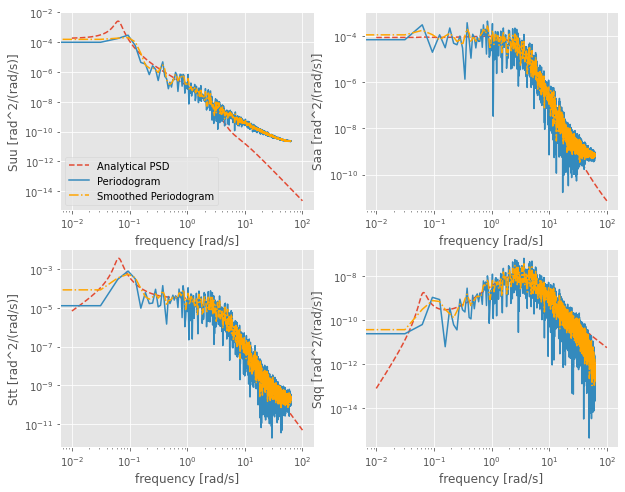

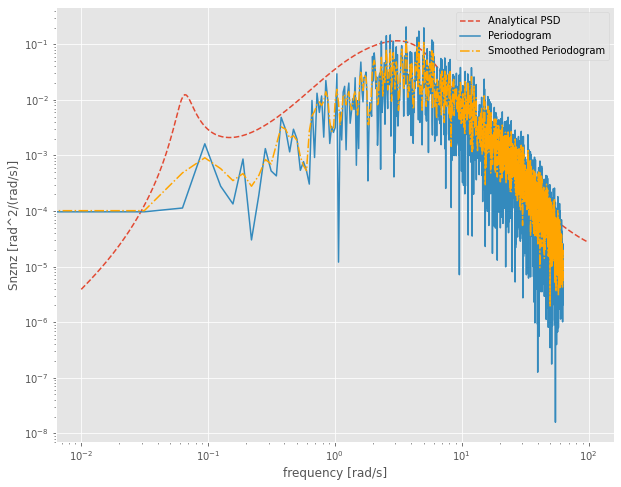

In [153]:


states = ['u', 'alpha', 'theta', 'qc/v', 'nz']
S_names = ["Suu", "Saa", "Stt", "Sqq", "Snznz"]

plt.figure()
for i in range(len(states)-1):
    # loglog plot
    plt.subplot(2, 2, i+1)
    plt.loglog(w, Sxx[:, i], linestyle='--', label = 'Analytical PSD')
    plt.loglog(omega, P_lst[i][:round(N/2)], label = 'Periodogram')
    plt.loglog(omega, P_lst_new[i][:round(N/2)], label = 'Smoothed Periodogram', linestyle = '-.', color = 'orange')
    plt.xlabel('frequency [rad/s]')
    plt.ylabel(f'{S_names[i]} [rad^2/(rad/s)]')
    if i == 0:
        plt.legend()
    # make the plots bigger
    plt.gcf().set_size_inches(10, 8)
    # save the plot
# plt.savefig(f'figures/PSDstates_vs_w.pdf')

# plot the PSD of nz vs omega (rad/s) with fancy colors
plt.figure()
plt.loglog(w, Sxx[:, -1], linestyle='--', label='Analytical PSD')
plt.loglog(omega, Pnz[:round(N/2)], label='Periodogram')
plt.loglog(omega, P_lst_new[-1][:round(N/2)], label='Smoothed Periodogram', linestyle='-.', color = 'orange')
plt.xlabel('frequency [rad/s]')
plt.ylabel('Snznz [rad^2/(rad/s)]')
plt.legend()
# make the plots bigger
plt.gcf().set_size_inches(10, 8)
# save the plot
# plt.savefig(f'figures/PSDnz_vs_w.pdf')



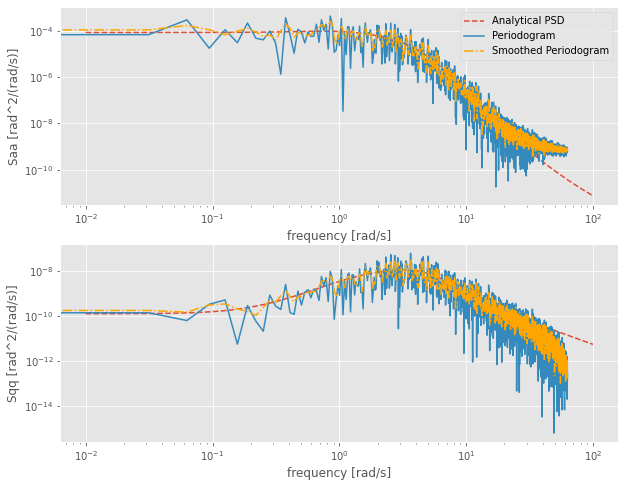

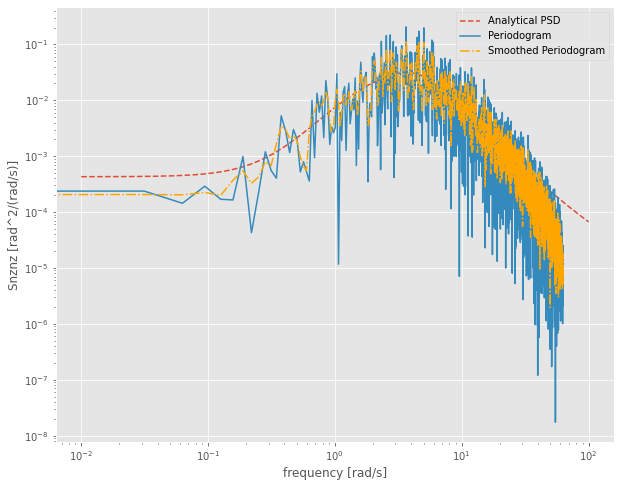

In [154]:


states_r = ['alpha','qc/v', 'nz']
S_names_r = ["Saa","Sqq", "Snznz"]

plt.figure()
for i in range(len(states_r)-1):
    # loglog plot
    plt.subplot(2, 1, i+1)
    plt.loglog(w, Sxx_red[:, i], linestyle='--', label='Analytical PSD')
    plt.loglog(omega, P_lst_r[i][:round(N/2)], label='Periodogram')
    plt.loglog(omega, P_lst_new_r[i][:round(
        N/2)], label='Smoothed Periodogram', linestyle='-.', color='orange')
    plt.xlabel('frequency [rad/s]')
    plt.ylabel(f'{S_names_r[i]} [rad^2/(rad/s)]')
    if i == 0:
        plt.legend()
    # make the plots bigger
    plt.gcf().set_size_inches(10, 8)
    # save the plot
# plt.savefig(f'figures/PSDstates_vs_w_red.pdf')

# plot the PSD of nz vs omega (rad/s) with fancy colors
plt.figure()
plt.loglog(w, Sxx_red[:, -1], linestyle='--', label='Analytical PSD')
plt.loglog(omega, Pnz_r[:round(N/2)], label='Periodogram')
plt.loglog(omega, P_lst_new_r[-1][:round(N/2)],
           label='Smoothed Periodogram', linestyle='-.', color='orange')
plt.xlabel('frequency [rad/s]')
plt.ylabel('Snznz [rad^2/(rad/s)]')
plt.legend()
# make the plots bigger
plt.gcf().set_size_inches(10, 8)
# save the plot
# plt.savefig(f'figures/PSDnz_vs_w_red.pdf')


4. Variances

i) The analytical power spectra

In [155]:
# COMPUTE VARIANCE THROUGH CRUDE INTEGRATION OF PSDs
# The variance will be equal to the integral of the PSD.

# FULL STATE
var = np.zeros(7)
for j in range(len(var)):
    for i in range(0, Nomega-1):
      var[j] = var[j]+(w[i+1]-w[i])*Sxx[i, j]

var = var/pi
# print('                                                 ')
# print('   Compute variances for n and a_z:              ')
# print('   Variance of nz: ', var[4])
# # Remember: var_az = E[(a*g)^2-mu_az]
# print('   Variance of az = g*nz: ', var[4]*g**2)
print('Full state variance:')
print(var)



# REDUCED STATE
var_red = np.zeros(Ar.shape[0])
for j in range(len(var_red)):
    for i in range(0, Nomega-1):
      var_red[j] = var_red[j]+(w[i+1]-w[i])*Sxx_red[i, j]

var_red = var_red/pi
# print('                                                 ')
# print('   Compute variances for n and a_z:              ')
# print('   Variance of nz: ', var[4])
# # Remember: var_az = E[(a*g)^2-mu_az]
# print('   Variance of az = g*nz: ', var[4]*g**2)
print('Reduced state variance:')
print(var_red)


Full state variance:
[2.31213342e-05 8.72382504e-05 6.25582099e-05 2.08918491e-08
 1.11519108e-04 1.11337680e-04 4.03643540e-04]
Reduced state variance:
[8.71970364e-05 2.08539783e-08 1.11519108e-04 1.11337680e-04
 4.03643540e-04]


In [122]:
# hatu = y[:, 0]
# alpha = y[:, 1]
# theta = y[:, 2]
# qcV = y[:, 3]
# hatug = y[:, 4]
# alphag = y[:, 5]
# alphagst = y[:, 6]


ii) Impulse response method

In [123]:
# impulse response method to find variance
# However, in practice, it is often difficult or impossible to create a perfect impulse function. Using an initial condition with zero input is an # alternative way to obtain the impulse response of the system.

# FULL STATE

u1 = np.zeros(N)
u = np.array([u1, u1, u1]).T
x0 = [B[:, 1], B[:, 2]]
final_var_ir = np.zeros(7)
for x_indx in range(len(x0)):
    # CALCULATION OF IMPULSE RESPONSES
    sys = cm.ss(A, B, C, D)
    h = cm.lsim(sys, u, t, x0[x_indx])[0]

    hatu = h[:, 0] * h[:, 0]
    alpha = h[:, 1] * h[:, 1]
    theta = h[:, 2] * h[:, 2]
    qcV = h[:, 3] * h[:, 3]
    hatug = h[:, 4] * h[:, 4]
    alphag = h[:, 5] * h[:, 5]
    alphagst = h[:, 6] * h[:, 6]

    dt_hatu = dt * hatu
    dt_alpha = dt * alpha
    dt_theta = dt * theta
    dt_qcV = dt * qcV
    dt_hatug = dt * hatug
    dt_alphag = dt * alphag
    dt_alphagst = dt * alphagst

    dt_lst = [dt_hatu, dt_alpha, dt_theta, dt_qcV, dt_hatug, dt_alphag, dt_alphagst]
    var_ir = [np.zeros(N) for i in range(7)]
    for v in range(len(var_ir)):
        for i in range(N-1):
            var_ir[v][i+1] = var_ir[v][i] + dt_lst[v][i]
               
        final_var_ir[v] = var_ir[v][-1]
        


In [164]:
# impulse response method to find variance
# However, in practice, it is often difficult or impossible to create a perfect impulse function. Using an initial condition with zero input is an # alternative way to obtain the impulse response of the system.

# REDUCED STATE

u1 = np.zeros(N)
u = np.array([u1, u1, u1]).T
x0_red = [Br[:, 1], Br[:, 2]]
final_var_ir_red = np.zeros(Ar.shape[0])
for x_indx in range(len(x0_red)):
    # CALCULATION OF IMPULSE RESPONSES
    sys_red = cm.ss(Ar, Br, Cr, Dr)
    h_red = cm.lsim(sys_red, u, t, x0_red[x_indx])[0]

    alpha_red = h_red[:, 0] * h_red[:, 0]
    qcV_red = h_red[:, 1] * h_red[:, 1]
    hatug_red = h_red[:, 2] * h_red[:, 2]
    alphag_red = h_red[:, 3] * h_red[:, 3]
    alphagst_red = h_red[:, 4] * h_red[:, 4]

    dt_alpha_red = dt * alpha_red
    dt_qcV_red = dt * qcV_red
    dt_hatug_red = dt * hatug_red
    dt_alphag_red = dt * alphag_red
    dt_alphagst_red = dt * alphagst_red

    dt_lst_red = [dt_alpha, dt_qcV, dt_hatug, dt_alphag, dt_alphagst]
    var_ir_red = [np.zeros(N) for i in range(Ar.shape[0])]
    for v in range(len(var_ir_red)):
        for i in range(N-1):
            var_ir_red[v][i+1] = var_ir_red[v][i] + dt_lst_red[v][i]

        final_var_ir_red[v] = var_ir_red[v][-1]


In [165]:
final_var_ir_red


array([8.61159320e-05, 2.24721693e-08, 0.00000000e+00, 1.22135859e-04,
       4.38232651e-04])

iii) var function

In [160]:
# ddof = 1 for unbiased estimator	
var_matlab = np.zeros(A.shape[0])
for i in range(len(var_matlab)):
    var_matlab[i] = np.var(y[:, i], ddof=1)
print(var_matlab)


[6.50529638e-06 9.27850041e-05 4.38918107e-05 2.04135655e-08
 9.29580823e-05 1.12959243e-04 4.13675370e-04]


In [166]:
# ddof = 1 for unbiased estimator
var_matlab_red = np.zeros(Ar.shape[0])
for i in range(len(var_matlab_red)):
    var_matlab_red[i] = np.var(y_red[:, i], ddof=1)
print(var_matlab_red)


[9.27440075e-05 2.03812025e-08 9.29580823e-05 1.12959243e-04
 4.13675370e-04]


In [127]:
# [2.31213342e-05 8.72382504e-05 6.25582099e-05 2.08918491e-08
#  1.85018662e-01 1.11519108e-04 1.11337680e-04]

# array([1.95506294e-06, 8.61534994e-05, 3.11496171e-05, 2.24960148e-08,
#        0.00000000e+00, 1.22135859e-04, 4.38232651e-04])


# [1.19504922e-05 7.74309606e-05 5.05281435e-05 1.83434975e-08
#  1.23212025e-04 9.75092978e-05 3.56748824e-04]
